In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from config import L2_DISTANCES_DIR

with open(os.path.join(f'{L2_DISTANCES_DIR}_checkpoint_24000', 'distances.json'), 'r') as f_obj:
    distances = json.load(f_obj)

In [2]:
from utils import setup_matplotlib
setup_matplotlib()

In [3]:
def get_df_min(distances: dict) -> pd.DataFrame:
    orig_urls, sim_urls, dists = [], [], []
    for orig_url, data in distances.items():
        if len(data) == 0:
            continue
        orig_urls += [orig_url]
        sim_url = min(distances[orig_url], key=lambda x: distances[orig_url][x])
        sim_urls += [sim_url]
        dists += [distances[orig_url][sim_url]]
    df = pd.DataFrame({
        'url_orig': orig_urls,
        'url_sim': sim_urls,
        'dist': dists,
    })
    return df

In [4]:
df = get_df_min(distances)

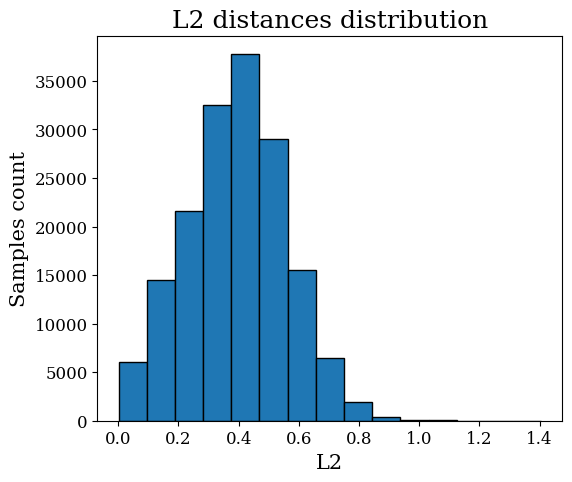

In [16]:
_, ax = plt.subplots(figsize=(6, 5))
ax.hist(df.dist, edgecolor='black', bins=15)
ax.set_ylabel('Samples count')
ax.set_xlabel('L2')
ax.set_title('L2 distances distribution')
plt.savefig(os.path.join('raport-data', 'l2-dist.pdf'),bbox_inches='tight');

In [6]:
# write a simple thread for downloading images using urls and saving them to a list

import requests
import threading
from io import BytesIO
from PIL import Image

# thread class

class DownloadThread(threading.Thread):
    def __init__(self, url, path):
        threading.Thread.__init__(self)
        self.url = url
        self.path = path
        self.image = None

    def run(self):
        r = requests.get(self.url, timeout=5)
        if r.status_code == 200:
            self.image = Image.open(BytesIO(r.content))

# download images
def download_images(urls):
    threads = []
    for url in urls:
        thread = DownloadThread(url, None)
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()
    return [thread.image for thread in threads]

In [7]:
def plot_imgs(orig, sim):
    _, axs = plt.subplots(1, 2)
    try:
        for img, title, idx in zip((orig, sim), ('original', 'duplicate candidate'), (0, 1)):
            axs[idx].imshow(img)
            axs[idx].set_title(title)
    except Exception as e:
        print('fail')
    plt.show()

99 0.4 0.5


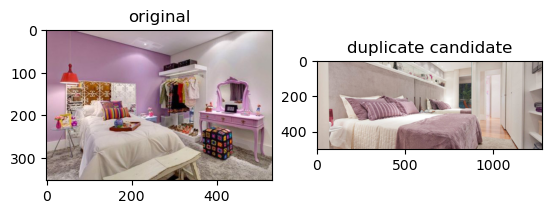

In [41]:
from IPython.display import clear_output

np.random.seed(1234)
thrs = np.linspace(0.0, 0.5, 6)
for lb, rb in zip(thrs[:-1], thrs[1:]):
    urls_orig = np.random.choice(df.loc[(df.dist>lb)&(df.dist<=rb)].url_orig, 200, replace=False)
    urls_sim = [df.loc[df.url_orig==url_orig].url_sim.values[0] for url_orig in urls_orig]
    orig_imgs = download_images(urls_orig)
    sim_imgs = download_images(urls_sim)
    idx = 0
    clear_output()
    for orig_img, sim_img in zip(orig_imgs, sim_imgs):
        print(idx, lb, rb)
        plot_imgs(orig_img, sim_img)
        idx += 1
        user_input = input()
        if user_input == 'q':
            break
        elif user_input == '-':
            idx -= 1
        clear_output()

In [7]:
results = pd.concat([
    pd.DataFrame({'lb': [0.0]*10, 'rb': [0.1]*10, 'duplicates_cnt': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]}),
    pd.DataFrame({'lb': [0.1]*10, 'rb': [0.2]*10, 'duplicates_cnt': [8, 10, 10, 10, 10, 10, 10, 10, 9, 9]}),
    pd.DataFrame({'lb': [0.2]*10, 'rb': [0.3]*10, 'duplicates_cnt': [7, 8, 6, 5, 6, 5, 7, 5, 7, 8]}),
    pd.DataFrame({'lb': [0.3]*10, 'rb': [0.4]*10, 'duplicates_cnt': [3, 2, 2, 1, 3, 3, 1, 1, 1, 2]}),
    pd.DataFrame({'lb': [0.4]*10, 'rb': [0.5]*10, 'duplicates_cnt': [1, 1, 1, 1, 0, 0, 1, 1, 1, 1]}),
])

In [8]:
results['[lb, rb]'] = results.apply(lambda x: f'[{x.lb}, {x.rb})', axis=1)

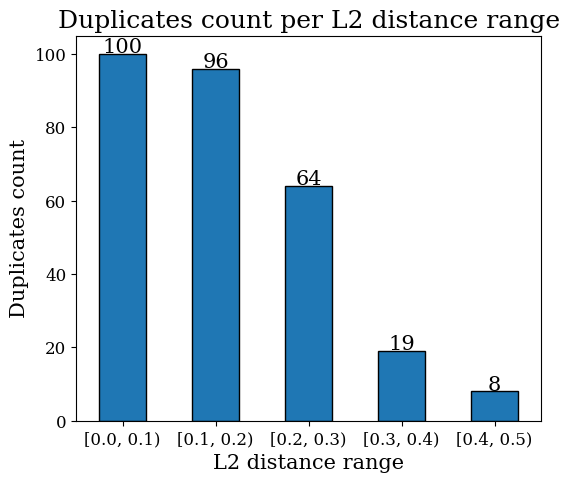

In [17]:
_, ax = plt.subplots(1, 1, figsize=(6, 5))
results.groupby('[lb, rb]').duplicates_cnt.sum().plot.bar(ax=ax, edgecolor='black')
ax.set_ylabel('Duplicates count')
ax.set_xlabel('L2 distance range')
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.set_title('Duplicates count per L2 distance range')
ax.bar_label(ax.containers[0], padding=-2)
plt.savefig(os.path.join('raport-data', 'l2-dist-duplicates.pdf'),bbox_inches='tight');
plt.show();